In [1]:
from fourlang.text_to_4lang import TextTo4lang
from fourlang.lexicon import Lexicon
from graphviz import Source
from scripts.parse_data import read_sherliic, build_graph
from scripts.similarity import Similarity

from tqdm import tqdm
preds = []
text_to_4lang = TextTo4lang(lang="en")
data = read_sherliic("data/dev.csv", ud_path="data/relation_index.tsv", keep_context=True)
data_frame = build_graph(data)

lexicon = Lexicon(lang="en")

similarity = Similarity(with_embedding=False)

In [2]:
data['premise_text'] = data["prem_argleft"] + " " + data["premise"] + " " + data["prem_argright"]

In [3]:
data['hyp_text'] = data["hypo_argleft"] + " " + data["hypothesis"] + " " + data["hypo_argright"]

In [4]:
data_frame

,premise,hypothesis,score
0,"[[[nsubj, ['nation', '1'], ['A', '0']], [prep,...","[[[nsubj, ['country', '1'], ['A', '0']], [prep...",1
1,"[[[dobj, ['hate', '1'], ['B', '0']], [nsubj, [...","[[[pobj, ['with', '1'], ['B', '0']], [prep, ['...",0
2,"[[[dobj, ['call', '1'], ['B', '0']], [nsubj, [...","[[[dobj, ['urge', '1'], ['B', '0']], [nsubj, [...",0
3,"[[[dobj, ['displace', '1'], ['B', '0']], [nsub...","[[[nsubj, ['compete', '1'], ['A', '0']], [prep...",0
4,"[[[nsubj, ['decide', '1'], ['A', '0']], [xcomp...","[[[nsubj, ['bomb', '1'], ['A', '0']], [dobj, [...",0
...,...,...,...
991,"[[[pobj, ['by', '1'], ['B', '0']], [prep, ['in...","[[[nsubj, ['conquer', '1'], ['A', '0']], [dobj...",1
992,"[[[nsubj, ['commit', '1'], ['A', '0']], [prep,...","[[[nsubj, ['use', '1'], ['A', '0']], [prep, ['...",0
993,"[[[pobj, ['in', '1'], ['B', '0']], [prep, ['co...","[[[rcmod, ['B', '0'], ['have', '1']], [nsubj, ...",0
994,"[[[dobj, ['stop', '1'], ['B', '0']], [nsubj, [...","[[[dobj, ['force', '1'], ['B', '0']], [nsubj, ...",1


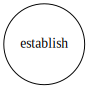

In [108]:
premise = text_to_4lang.process_text("To establish or apply by authority", method="expand", depth=0)
dot_graph_premise = premise.to_dot()
Source(dot_graph_premise)

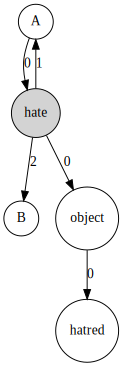

In [6]:
premise = text_to_4lang.process_deps(data_frame.iloc[1]["premise"], method="expand", depth=1)
dot_graph_premise = premise.to_dot()
Source(dot_graph_premise)

In [28]:
preds = []
for i in tqdm(range(len(data))):
    index = i
    premise = data["premise_text"][index]
    hypothesis = data["hyp_text"][index]
    score = data.score[index]
    graph_premise = text_to_4lang.process_text(premise, method="expand", depth=2, blacklist=["in", "on", "of", ])
    graph_hypothesis = text_to_4lang.process_text(hypothesis, method="expand", depth=1)
    pred = similarity.asim_jac_nodes(graph_premise, graph_hypothesis)
    if pred > 0.5:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 996/996 [04:48<00:00,  3.13it/s]


In [8]:
def asim_jac_edges(graph_premise, graph_hypothesis):
    """
    Asymmetric Jaccard similarity between the edges of the definition graphs
    :param graph_premise: the definition graph of the premise
    :param graph_hypothesis: the definition graph of the hypothesis
    :return: the ratio of overlapping edges per the length of the hypothesis definition
    """
    prem = set([(clear_node(s), clear_node(r), e['color'])
                for (s, r, e) in graph_premise.G.edges(data=True)])
    hyp = set([(clear_node(s), clear_node(r), e['color'])
               for (s, r, e) in graph_hypothesis.G.edges(data=True)])
    sim = hyp & prem
    if not sim or len(hyp) == 0:
        return 0
    else:
        return float(len(sim)) / len(hyp)

In [9]:
import re
def clear_node(node):
    """
    Clears the node from the 4lang id parts
    :param node: the text to clear
    :return: the cleared text
    """
    return re.sub(r'_[0-9][0-9]*', '', node.lower())

In [57]:
preds = []
for i in tqdm(range(len(data_frame))):
    index = i
    premise = data_frame["premise"][index]
    hypothesis = data_frame["hypothesis"][index]
    score = data.score[index]
    graph_premise = text_to_4lang.process_deps(premise, method="substitute", depth=4, blacklist=["in", "on", "of"])
    graph_hypothesis = text_to_4lang.process_deps(hypothesis, method="substitute", depth=2)
    pred = asim_jac_edges(graph_premise, graph_hypothesis)
    if pred > 0.2:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 996/996 [00:14<00:00, 74.44it/s]


In [58]:
from sklearn.metrics import precision_recall_fscore_support as pr
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), preds)

print("Precision: " +  str(bPrecis[1]))
print("Recall: " +  str(bRecall[1]))
print("Fscore: " +  str(bFscore[1]))

Precision: 0.6347826086956522
Recall: 0.22054380664652568
Fscore: 0.32735426008968616


In [12]:
text_to_4lang.get_definition("impose")

'To establish or apply by authority.'

In [ ]:
gold = data_frame.score.tolist()

for i, score in enumerate(gold):
    if preds[i] == 0 and score == 1:
        print(i)

In [123]:
data.iloc[72]

prem_argleft                                            A
premise                                    is overtaking 
prem_argright                                           B
hypo_argleft                                            B
hypothesis                              is competing with
hypo_argright                                           A
score                                                   1
premise_ud                      nsubj^-___overtake___dobj
hypothesis_ud    pobj^-___with___prep^-___compete___nsubj
premise_text                           A is overtaking  B
hyp_text                            B is competing with A
Name: 72, dtype: object

In [25]:
graph_premise = text_to_4lang.process_deps(data_frame.iloc[72].premise, method="substitute", depth=1, blacklist=["in", "on", "of"])
graph_hypothesis = text_to_4lang.process_deps(data_frame.iloc[72].hypothesis, method="substitute", depth=1)

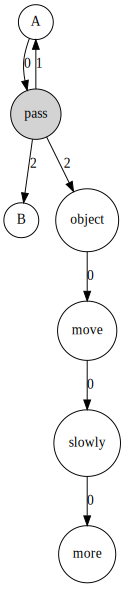

In [26]:
dot_graph_premise = graph_premise.to_dot()
Source(dot_graph_premise)

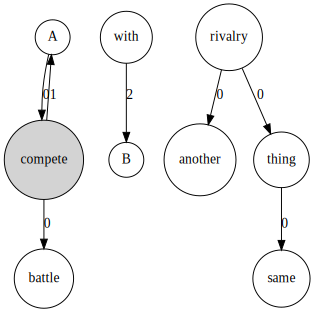

In [122]:
dot_graph_premise = graph_hypothesis.to_dot()
Source(dot_graph_premise)

In [113]:
asim_jac_edges(graph_premise, graph_hypothesis)

0.2